# Implémentation de l'Extended RLM attaché à un MLP pour prédire les relations spatiales

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pybresenham

  Preparing metadata (setup.py) ... done
  Created wheel for pybresenham: filename=PyBresenham-0.0.7-py3-none-any.whl size=11372 sha256=2aa668a45e093eb1e80f478ff1fed9faf7ae3d058a719fac88c8065478e528dc
  Stored in directory: /root/.cache/pip/wheels/03/20/4d/118c335b1fe730096b9942820aa6398a1abad744680fd4f809
Successfully built pybresenham


In [3]:
import json
import math
import numpy as np
from PIL import Image
from pybresenham import line as bline

### Code de Logan Servant pour l'Extended RLM (https://github.com/Logan-wilson/extendedRLM/tree/main)

In [4]:
def isContour(obj, x, y):
    """
    Returns whether a given pixel is a contour of an object using a 4-connected space.

    :param obj: object the pixel comes from.
    :param x: x coordinate of the pixel.
    :param y: y coordinate of the pixel.
    :return: True if pixel(x,y) is a contour of the object, False otherwise.
    """
    if x < 0 or y < 0 or x >= len(obj) or y >= len(obj[0]) or not (obj[x][y]):  # not part of the object -> not a contour.
        return False
    if x == 0 or y == 0 or x == len(obj) - 1 or y == len(obj) - 1:  # is along the border of image so it's an object's contour.
        return True
    # if a pixel in a 4-connected space is void, it means the original pixel is a contour of the object.
    return not (obj[x - 1][y]) or not (obj[x + 1][y]) or not (obj[x][y - 1]) or not (obj[x][y + 1])


def object_contour(obj):
    """
    Goes through all pixels of the image of the object and returns a list of all pixels considered as contour in a
    4-connected space.

    :param obj: object image to detect contours of.
    :return: list of tuples(x,y) with x and y = coordinates of each pixel.
    """
    cont = []
    for i in range(len(obj)):
        for j in range(len(obj)):
            if isContour(obj, i, j):
                cont.append((i, j))
    return cont


def get_corner_pixel(contour):
    """
    Find the pixel that is going to act as the pivot point of the convex hull computation.

    :param contour: list of points considered as contours of the image.
    :return: tuple(x,y), the point minimal x value or y value if multiple points have the same x min value.
    """
    min_pix = (9999, 9999)
    for pixel in contour:
        if pixel[0] < min_pix[0] or (pixel[0] == min_pix[0] and pixel[1] < min_pix[1]):
            min_pix = pixel
    return min_pix


def compute_slope(p1, p2):
    """
    Compute the slope of a vector defined by its 2 ends. If the x value of both points are equals, return 1 to avoid
    division by zero.

    :param p1: first end of the vector.
    :param p2: second end of the vector.
    :return: slope of the vector.
    """
    if p2[0] - p1[0] == 0:
        return 1
    return (p2[1] - p1[1]) / (p2[0] - p1[0])


def compute_power(line_p1, line_p2, point):
    """
    Compute the power of a vector to a point.
    :param line_p1: first endpoint of the vector.
    :param line_p2: second endpoint of the vector.
    :param point: point used to compare the vector to.
    :return: float value, either negative or positive (>0 -> left side of the vector, <0 -> right side of the vector).
    """
    dy = line_p2[1] - line_p1[1]
    dx = line_p2[0] - line_p1[0]
    return int(dy * (point[0] - line_p1[0]) - dx * (point[1] - line_p1[1]))


def sortby_slope(minpix, contour):
    """
    Create a copy and sort the list of contour points according to the slope of each point compared to the starting
    point of the convex hull computation.
    :param minpix: starting point of the convex hull computation (min(x), min(y)).
    :param contour: list of the points considered as a contour.
    :return:sorted list.
    """
    sorted_contour = sorted(contour, key=lambda s: compute_slope(minpix, s))
    return sorted_contour


def convex_hull(obj):
    """
    compute the convex hull of an object using Graham's algorithm.

    1) find the pivot point (x min, or y min).
    2) compute slopes of line of pivot point to all other points of the object.
    3) sort points by their slope (with the pivot point).
    4) remove incrementally concave angles using the power of a segment to a point.

    :param obj: object to compute the convex hull of.
    :return: point used as starting point, list of points from the convex hull.
    """
    contour = object_contour(obj)
    min_pix = get_corner_pixel(contour)
    sorted_contour = sortby_slope(min_pix, contour)
    ch = sorted_contour
    i = 1
    while i < len(ch) - 1:
        power = compute_power(ch[i - 1], ch[i + 1], ch[i])
        if power >= 0:
            i += 1
        else:
            ch.pop(i)
            i -= 1
    return min_pix, ch


def compute_polygon(min_pix, ch):
    """
    compute the polygon that acts as a convex hull of an object.
    :param min_pix: starting point of the convex hull algorithm.
    :param ch: list of points acting as the convex hull.
    :return: list of bresenham points to draw.
    """
    points = list(bline(min_pix[0], min_pix[1], ch[0][0], ch[0][1]))
    for i in range(len(ch) - 1):
        x1 = ch[i]
        x2 = ch[i + 1]
        points.extend(list(bline(x1[0], x1[1], x2[0], x2[1])))
    points.extend(list(bline(ch[-1][0], ch[-1][1], min_pix[0], min_pix[1])))
    return points


def get_closest_convex_hull_points(points1, points2):
    """
    Compute the shortest line from any two pixels of each convex hulls. Used for the computation of the middle point of the
    RLM.

    :param points1: list of points from the first convex hull.
    :param points2: list of points from the second convex hull.
    :return: middle point of the shortest line.
    """
    min1 = 0
    min2 = 0
    dist = 9999
    for p1 in points1:
        for p2 in points2:
            if manhattan(p1[0], p1[1], p2[0], p2[1]) < dist:
                dist = manhattan(p1[0], p1[1], p2[0], p2[1])
                min1 = p1
                min2 = p2
    return min1, min2


def connected8_check(x, y, obj_list):
    """
    Checks if, for a given x and y values, a point is in an 8-connected space.

    :param x: x value of the point.
    :param y: y value of the point.
    :param obj_list: list of points to check, is mainly used to compare intersection with a convex hull.
    :return: True if (x,y) are coordinates of, or a neighbor of a point in the list.
    """
    matrix = [(x + 1, y + 1), (x + 1, y), (x + 1, y - 1), (x, y - 1), (x, y), (x, y - 1), (x - 1, y + 1), (x - 1, y), (x - 1, y - 1)]
    return any(pt in obj_list for pt in matrix)


def manhattan(x1, y1, x2, y2):
    """
    return the manhattan distance of two points. Since the distance is computed on discretized points (pixels), the
    distance is an integer.

    :param x1: x value of first point.
    :param y1: y value of first point.
    :param x2: x value of second point.
    :param y2: y value of second point.
    :return: manhattan distance.
    """
    return abs(x2 - x1) + abs(y2 - y1)

In [5]:
def image_segmentation(imagename: str, backgroundcolor):
    """
    Segment images such as SimpleShapes images where the background color is removed, and masks of objects of the same
    colors are obtained.

    :param imagename: name of the image to mask.
    :param backgroundcolor: Color of the background to remove.
    :return: list of binary images (mask of object 1, mask of object 2).
    """
    filepath = imagename.split("/")
    filename = filepath[-1]
    path = '/'.join(filepath[:-1])
    im = Image.open(f"{path}/{filename}")
    im = im.convert('RGBA')
    data = np.array(im)
    colors = set(tuple(clr) for p in data for clr in p)
    colors.remove(backgroundcolor)
    objects = []
    for n, c in enumerate(colors):
        data_copy = data.copy()
        R, G, B, A = data.T
        non_colored_area = (R != c[0]) & (G != c[1]) & (B != c[2])
        data_copy[..., :-1][non_colored_area.T] = (0, 0, 0)
        colored_area = ~non_colored_area
        data_copy[..., :-1][colored_area.T] = (255, 255, 255)
        objects.append(colored_area)
    return objects


def center_point(objects):
    """
    Find the center points between both object using convex hulls. The point found correponds to the point from which
    half lines are drawn to compute the radial line model.

    :param objects: both objects found in the images.
    :return: x and y coordinates of the middle point.
    """
    hulls = []
    for obj in objects:
        min_pix, c_hull = convex_hull(obj)
        hull = []
        size_c_hull = len(c_hull)
        for p in range(size_c_hull):
            hull.extend(list(
                bline(c_hull[p][0], c_hull[p][1], c_hull[(p + 1) % size_c_hull][0], c_hull[(p + 1) % size_c_hull][1])))
        hulls.append(hull)
    pt1 = barycentre(objects[0])
    pt2 = barycentre(objects[1])
    lin = list(bline(pt1[0], pt1[1], pt2[0], pt2[1]))
    it1 = False
    it2 = False
    fp1 = None
    fp2 = None
    for pt in lin:  # detects when the line crosses the convex hull using an 8-connected space.
        if connected8_check(pt[0], pt[1], hulls[0]) and not it1:
            it1 = True
            fp1 = (pt[0], pt[1])
        if connected8_check(pt[0], pt[1], hulls[1]) and not it2:
            it2 = True
            fp2 = (pt[0], pt[1])
        if it1 and it2:
            break
    if fp1 is None:
        fp1 = pt1
    if fp2 is None:
        fp2 = pt2
    return int((fp1[0] + fp2[0]) / 2), int((fp1[1] + fp2[1]) / 2)


def lines_diameters(objects, x, y, step):
    """
    Returns a list of lines and diameters from which to compute forces and the radial line mode.

    :param objects: objects to compute data from.
    :param x: x coordinate of the middle points.
    :param y: y coordinate of the middle points.
    :param step: step of the angle.
    :return: (List of z half-lines, List of z/2 diameters)
    """
    radius = radial_line_model_radius(objects, x, y)
    lines = []
    diameters = []
    for i in range(int(math.pi * 2 / step)):
        point = round(x + radius * math.cos(step * -i)), round(y + radius * math.sin(step * -i))
        point_2 = round(x + radius * math.cos(step * -i + math.pi)), round(y + radius * math.sin(step * -i + math.pi))
        lines.append(list(bline(x, y, point[0], point[1])))
        diameters.append(list(bline(point[0], point[1], point_2[0], point_2[1])))
    return lines, diameters


def barycentre(obj):
    """
    Return the barycentre of the object.

    :param obj: object to compute the barycentre from : usually 2D binary list.
    :return:x and y coordinates.
    """
    x_pixels = [x for x in range(len(obj)) for y in range(len(obj[x])) if obj[x][y]]
    y_pixels = [y for x in range(len(obj)) for y in range(len(obj[x])) if obj[x][y]]
    return int(sum(x_pixels) / len(x_pixels)), int(sum(y_pixels) / len(y_pixels))


def radial_line_model_radius(objects, x, y):
    """
    Compute the minimum radius of the RLM needed to cover the two objects to compute Spatial Relations from.

    :param objects: list of two 2D binary list. (binary masks of both of the objects).
    :param x: x coordinates of the middle point.
    :param y: y coordinates of the middle point.
    :return: Integer: maximum length between the middle point and the farthest point of any object.
    """
    bounding_boxes = []
    for obj in objects:
        maxX = maxY = 0
        minX = minY = len(obj)
        for i, listJ in enumerate(obj):
            for j, value in enumerate(listJ):
                if value:
                    minX = i if i < minX else minX
                    minY = j if j < minY else minY
                    maxX = i if i > maxX else maxX
                    maxY = j if j > maxY else maxY
        bounding_boxes.append([minX, maxX, minY, maxY])
    x_max = 0
    y_max = 0
    o = 0
    for bb in bounding_boxes:
        for x1 in range(2):
            for y1 in range(2):
                if manhattan(x, y, bb[x1], bb[y1 + 2]) > o:
                    o = manhattan(x, y, bb[x1], bb[y1 + 2])
                    x_max = bb[x1]
                    y_max = bb[y1 + 2]
    return int(math.dist((x, y), (x_max, y_max)))


def forces(objects, diameters, force_type):
    """
    Compute forces between the objects.

    :param objects: list of two 2D binary list. (binary masks of both of the objects).
    :param diameters: list of diameters from the middle point to compute forces from.
    :param force_type: type of force, usually f=0 or f=2 is used.
    :return: force computed from each diameter in a list. Can be constructed as a histogram.
    """
    travels = []
    for line in diameters:
        line_travel = []
        for pt in line:
            if 0 <= pt[0] < len(objects[1]) and 0 <= pt[1] < len(objects[1][0]) and objects[1][pt[0]][pt[1]]:
                line_travel.append("A")
            elif 0 <= pt[0] < len(objects[0]) and 0 <= pt[1] < len(objects[0][0]) and objects[0][pt[0]][pt[1]]:
                line_travel.append("B")
            else:
                line_travel.append("_")
        travels.append(line_travel)
    forces = []
    for i, fline in enumerate(travels):
        force = 0
        if 'A' in fline and 'B' in fline:
            for p in range(len(fline)):
                if fline[p] == 'A':
                    for r in range(p, len(fline)):
                        if fline[r] == 'B':
                            if force_type == 0:
                                force += int(math.dist((diameters[i][p][0], diameters[i][p][1]), (diameters[i][r][0], diameters[i][r][1])))
                            else:
                                dist = int(math.dist((diameters[i][p][0], diameters[i][p][1]), (diameters[i][r][0], diameters[i][r][1])))
                                force += math.log(pow(dist + 1, 2) / (dist * (dist + 2)))
        forces.append(force)
    return forces


def radial_line_model(lines, objects):
    """
    Compute the Radial Line Model data  from the objects on the lines.

    :param lines: half-lines from the middle point.
    :param objects: list of two 2D binary list. (binary masks of both of the objects).
    :return: list of the size of the number of half-lines.
    """
    histObj1 = []
    histObj2 = []
    for line in lines:
        length = len(line)
        histObj1.append(len([p for p in line if point_overlap(p, objects[0])]) / length)
        histObj2.append(len([p for p in line if point_overlap(p, objects[1])]) / length)
    return histObj1, histObj2


def point_overlap(pt, obj):
    """
    Return a Boolean that determines whether a point is overlapping on an object.

    :param pt: pt -> (x,y)
    :param obj: 2D list (list of lists) of boolean values.
    :return: True if (x,y) of pt is True in the list of the obj.
    """
    if 0 <= pt[0] < len(obj) and 0 <= pt[1] < len(obj[0]):
        return obj[pt[0]][pt[1]]
    return False


def image_processing(imagename, background, step, force_type):
    """
    Compute from an image, the RLM of the first and the second object and forces histogram.
    :param imagename: name of the file of the image.
    :param background: background color of the image.
    :param step: step of the angle needed to compute half-lines and diameters for the RLM and F-histogram.
    :param force_type: type of force to use for the computation (usually 0 or 2).
    :return: 3 histograms of the same size: RLM1, RLM2, F-histogram.
    """
    objects = image_segmentation(imagename, background)
    x, y = center_point(objects)
    lines, diameters = lines_diameters(objects, x, y, step * math.pi / 180)
    rlm1, rlm2 = radial_line_model(lines, objects)
    force = forces(objects, diameters, force_type)
    return rlm1, rlm2, force


def SpatialSense_learning(folder, annots, step_deg, force_type):
    """
    Uses annotations from the SpatialSense dataset to segment objects to save histograms value in a json.

    :param folder: folder where SpatialSense images are saved.
    :param annots: path to the annotation file (.json)
    :param step_deg: step of the angle to use for computation of the histograms. In Degree.
    :param force_type: type of force to use.
    :return: list of all Histograms of step_deg*3 (RLM1, RLM2, F-Histogram) value, list of predicates of the images.
    """
    data = []
    number = 0
    forces_data = []
    relation = []
    step_rad = step_deg * math.pi / 180
    for ant in annots:
        if 'flickr' in ant["url"]:
            path = folder + "flickr/"
        else:
            path = folder + "nyu/"
        if '/' in path:
            path += ant["url"].split("/")[-1]
        size_x = ant["width"]
        size_y = ant["height"]
        for rel in ant["annotations"]:
            predicate = rel["predicate"]
            if rel["label"] and predicate in ["to the left of", "to the right of", "above", "under"]:
                # print(rel)
                sub = rel["subject"]
                obj = rel["object"]
                obj_img = [[bbox_value(obj, x, y) for y in range(size_x)] for x in range(size_y)]
                sub_img = [[bbox_value(sub, x, y) for y in range(size_x)] for x in range(size_y)]
                objs = [sub_img, obj_img]
                x, y = center_point(objs)
                lines, diameters = lines_diameters(objs, x, y, step_rad)
                rlm1, rlm2 = radial_line_model(lines, objs)
                force = forces(objs, diameters, force_type)
                data.append({
                    'filename':path,
                    "rel": predicate,
                    "sub": sub["name"],
                    "obj": obj["name"],
                    'forces': force + rlm1 + rlm2
                })
                number += 1
                forces_data.append(force + rlm1 + rlm2)
                relation.append(predicate)
    print(number)
    with open("output/SpatialSense_data.json", "w") as f:
        json.dump(data, f, indent=2)
    return forces, relation


def bbox_value(obj, x, y):
    bbox = obj["bbox"]
    x_min = bbox[0]
    x_max = bbox[1]
    y_min = bbox[2]
    y_max = bbox[3]
    return y_min <= y <= y_max and x_min <= x <= x_max

### test du calcul de l'Extended RLM sur une paire d'image de notre dataset

In [6]:
def test_RLM_on_image(object_image_path, subject_image_path, step, force_type):
    """
    Test RLM computation on a single pair of PNG segmented images.

    :param object_image_path: Path to the segmented PNG image of the object.
    :param subject_image_path: Path to the segmented PNG image of the subject.
    :param step: Angle step in degrees for RLM computation.
    :param force_type: Type of force to compute (0 or 2).
    :return: Computed RLM features and forces.
    """
    # Load object and subject masks
    object_mask = load_mask_from_png(object_image_path)
    subject_mask = load_mask_from_png(subject_image_path)

    # Combine masks into a list
    objects = [object_mask, subject_mask]

    # Compute center point
    x, y = center_point(objects)

    # Compute radial lines and diameters
    lines, diameters = lines_diameters(objects, x, y, step * np.pi / 180)

    # Compute RLM for both objects
    rlm1, rlm2 = radial_line_model(lines, objects)

    # Compute force histogram
    force_histogram = forces(objects, diameters, force_type)

    # Combine RLMs and forces into a single feature vector
    rlm_features = rlm1 + rlm2 + force_histogram

    print(f"Computed RLM Features: {rlm_features}")
    return rlm_features


def load_mask_from_png(png_path):
    """
    Load a binary mask from a PNG file. Assumes the object is white (255) on a black (0) background.

    :param png_path: Path to the PNG file.
    :return: Binary mask as a 2D NumPy array.
    """
    image = Image.open(png_path).convert('L')
    binary_mask = np.array(image) > 128
    return binary_mask


object_image_path = "/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/masks/12061816_4158924343_object_mask_1.png"
subject_image_path = "/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/masks/12061816_4158924343_subject_mask_1.png"
step = 3  # Angle step in degrees
force_type = 2  # Type of force to compute

test_RLM_on_image(object_image_path, subject_image_path, step, force_type)


Computed RLM Features: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0071174377224199285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05054151624548736, 0.08791208791208792, 0.10780669144981413, 0.13257575757575757, 0.15057915057915058, 0.1626984126984127, 0.17142857142857143, 0.19747899159663865, 0.2314410480349345, 0.24545454545454545, 0.26540284360189575, 0.295, 0.3459715639810427, 0.36818181818181817, 0.388646288209607, 0.3949579831932773, 0.40408163265306124, 0.40476190476190477, 0.39768339768339767, 0.39015151515151514, 0.3680297397769517, 0.3516483516483517, 0.3104693140794224, 0.31785714285714284, 0.3202846975088968, 0.31802120141342755, 0.31448763250883394, 0.30742049469964666, 0.302491103202847, 0.3357142857142857, 0.34657039711191334, 0.355311355311

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0071174377224199285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05054151624548736,
 0.08791208791208792,
 0.10780669144981413,
 0.13257575757575757,
 0.15057915057915058,
 0.1626984126984127,
 0.17142857142857143,
 0.19747899159663865,
 0.2314410480349345,
 0.24545454545454545,
 0.26540284360189575,
 0.295,
 0.3459715639810427,
 0.36818181818181817,
 0.388646288209607,
 0.3949579831932773,
 0.40408163265306124,
 0.40476190476190477,
 0.39768339768339767,
 0.39015151515151514,
 0.3680297397769517,
 0.3516483516483517,
 0.3104693140794224,
 0.31785714285714284,
 0.3202846975088968,
 0.31802120141342755,
 0.31448763250883394,
 0.30742049469964666,
 0.302

In [7]:
def visualize_misclassified_examples(misclassified_details, dataset, images_folder):
    """
    Visualize misclassified examples with their corresponding images.

    :param misclassified_details: List of misclassified details (true label, predicted label, index).
    :param dataset: Original dataset DataFrame containing image and annotation details.
    :param images_folder: Path to the folder containing segmentation masks.
    """
    for true, pred, idx in misclassified_details[:10]:  # Limit to first 10 examples for visualization
        row = dataset.iloc[idx]
        image_name = row['Image']
        annotation_index = row['Annotation_Index']

        # Construct paths to subject and object masks
        subject_mask_path = os.path.join(images_folder, f"{os.path.splitext(image_name)[0]}_subject_mask_{annotation_index}.png")
        object_mask_path = os.path.join(images_folder, f"{os.path.splitext(image_name)[0]}_object_mask_{annotation_index}.png")

        # Load and display the images
        try:
            subject_image = Image.open(subject_mask_path)
            object_image = Image.open(object_mask_path)

            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(subject_image, cmap="gray")
            plt.title(f"Subject Mask\n{image_name}")

            plt.subplot(1, 2, 2)
            plt.imshow(object_image, cmap="gray")
            plt.title("Object Mask")

            plt.suptitle(f"True: {true}, Predicted: {pred}")
            plt.show()
        except Exception as e:
            print(f"Error loading images for {image_name} with annotation {annotation_index}: {e}")

### Calcul de l'Extended RLM + training MLP sur toutes nos images

In [8]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def load_dataset(csv_path):
    """
    Load the dataset CSV file and return it as a DataFrame.
    """
    return pd.read_csv(csv_path)

def load_mask(png_path):
    """
    Load a binary mask from a PNG file.
    Assumes objects are white (255) and the background is black (0).
    """
    image = Image.open(png_path).convert('L')
    binary_mask = np.array(image) > 128
    return binary_mask

def compute_rlm_features(subject_mask_path, object_mask_path, step=3, force_type=2):
    """
    Compute RLM features for a subject-object pair.

    :param subject_mask_path: Path to the subject mask PNG file.
    :param object_mask_path: Path to the object mask PNG file.
    :param step: Angle step in degrees for RLM computation.
    :param force_type: Type of force to compute (0 or 2).
    :return: Combined RLM features as a list.
    """
    subject_mask = load_mask(subject_mask_path)
    object_mask = load_mask(object_mask_path)

    if subject_mask.shape != object_mask.shape:
        min_rows = min(subject_mask.shape[0], object_mask.shape[0])
        min_cols = min(subject_mask.shape[1], object_mask.shape[1])
        subject_mask = subject_mask[:min_rows, :min_cols]
        object_mask = object_mask[:min_rows, :min_cols]

    objects = [subject_mask, object_mask]

    # Compute center point
    try:
        x, y = center_point(objects)
    except Exception as e:
        raise ValueError(f"Failed to compute center point: {e}")

    # Compute radial lines and diameters
    try:
        lines, diameters = lines_diameters(objects, x, y, step * np.pi / 180)
    except Exception as e:
        raise ValueError(f"Failed to compute lines and diameters: {e}")

    # Compute RLM for both objects
    try:
        rlm1, rlm2 = radial_line_model(lines, objects)
    except Exception as e:
        raise ValueError(f"Failed to compute radial line model: {e}")

    # Compute force histogram
    try:
        force_histogram = forces(objects, diameters, force_type)
    except Exception as e:
        raise ValueError(f"Failed to compute forces: {e}")

    # Combine RLMs and forces into a single feature vector
    return rlm1 + rlm2 + force_histogram


def prepare_training_data(df, images_folder, step=3, force_type=2):
    """
    Prepare the training data by computing RLM features for all subject-object pairs.

    :param df: DataFrame containing the dataset information.
    :param images_folder: Path to the folder containing segmentation masks.
    :param step: Angle step in degrees for RLM computation.
    :param force_type: Type of force to compute (0 or 2).
    :return: Tuple (X, y) where X is the feature matrix and y is the target labels.
    """
    X = []
    y = []
    filtered_df = df[df['Label'] == True]
    print(f'dataset 2 :',len(filtered_df))

    for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="Processing data"):
        image_name = row['Image']
        annotation_index = row['Annotation_Index']
        relation = row['Relation']


        subject_mask_path = os.path.join(images_folder, f"{os.path.splitext(image_name)[0]}_subject_mask_{annotation_index}.png")
        object_mask_path = os.path.join(images_folder, f"{os.path.splitext(image_name)[0]}_object_mask_{annotation_index}.png")

        try:
            # Compute RLM features
            features = compute_rlm_features(subject_mask_path, object_mask_path, step, force_type)
            X.append(features)
            y.append(relation)
        except Exception as e:
            print(f"Error processing {image_name} with annotation {annotation_index}: {e}")

    return np.array(X), np.array(y)

def train_mlp(X, y, dataset, images_folder, print_scores=True):
    """
    Train an MLP classifier on the given data and display a confusion matrix.
    Also visualizes misclassified examples with their images.

    :param X: Feature matrix.
    :param y: Target labels.
    :param dataset: Original dataset DataFrame containing image and annotation details.
    :param images_folder: Path to the folder containing segmentation masks.
    :return: Trained MLP model.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Train the MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(4, 448), max_iter=1000, solver='adam', random_state=42)
    mlp.fit(X_train, y_train)

    # Optionally perform cross-validation
    if print_scores:
        scores = cross_val_score(mlp, X, y, cv=5, scoring='accuracy', n_jobs=-1)
        print("Cross-Validation Results:")
        print("Mean Accuracy: %0.2f%%" % (scores.mean() * 100))
        print("Accuracy Standard Deviation: %0.2f%%" % (scores.std() * 100))

    # Make predictions
    y_pred = mlp.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=mlp.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=mlp.classes_, yticklabels=mlp.classes_, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Identify misclassified examples
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]
    misclassified_details = [(y_test[i], y_pred[i], i) for i in misclassified_indices]

    print("\nMisclassified Examples:")
    for true, pred, idx in misclassified_details:
        original_image_name = dataset.iloc[idx]['Image']
        print(f"Index: {idx}, Original Image: {original_image_name}, True: {true}, Predicted: {pred}")

    # Visualize misclassified examples
    visualize_misclassified_examples(misclassified_details, dataset, images_folder)

    return mlp


csv_path = "/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/masks/relations.csv"
images_folder = "/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/masks"

dataset = load_dataset(csv_path)
print(f'dataset 1 :',len(dataset))

if os.path.exists("/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/rlm_features.npz"):
    data = np.load("/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/rlm_features.npz")
    X = data['X']
    y = data['y']
    print("Loaded features and labels from 'rlm_features.npz'")
    print(f"Dataset length: {len(X)} samples")
else:
    dataset = load_dataset(csv_path)
    X, y = prepare_training_data(dataset, images_folder)
    np.savez("/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/rlm_features.npz", X=X, y=y)
    print("Features and labels saved")
    print(f"Dataset length: {len(X)} samples")


dataset 1 : 3204
Loaded features and labels from 'rlm_features.npz'
Dataset length: 1575 samples


Cross-Validation Results:
Mean Accuracy: 86.92%
Accuracy Standard Deviation: 2.59%
Classification Report:
                 precision    recall  f1-score   support

          above       0.86      0.91      0.88        46
 to the left of       0.87      0.94      0.90        65
to the right of       0.81      0.92      0.87        66
          under       0.92      0.80      0.86       138

       accuracy                           0.87       315
      macro avg       0.86      0.90      0.88       315
   weighted avg       0.88      0.87      0.87       315



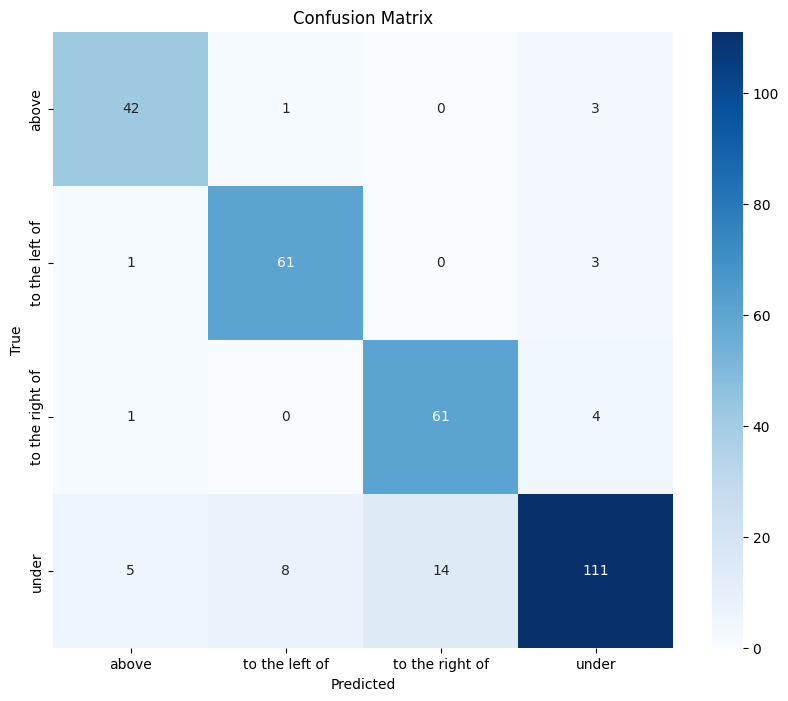


Misclassified Examples:
Index: 13, Original Image: 29909644074_9ed8c3265f.jpg, True: under, Predicted: to the left of
Index: 15, Original Image: 16142447362_8caebb1960.jpg, True: to the right of, Predicted: above
Index: 20, Original Image: nyu_living_room_0022_r-1313944963.935617-806622263.png, True: above, Predicted: under
Index: 27, Original Image: 31148685350_ba35a1f897.jpg, True: to the left of, Predicted: under
Index: 44, Original Image: 27112526385_98fe96b097.jpg, True: under, Predicted: to the right of
Index: 60, Original Image: 7312706784_cd76b62cf0.jpg, True: under, Predicted: to the right of
Index: 71, Original Image: 29762008044_79b620a837.jpg, True: to the left of, Predicted: under
Index: 79, Original Image: 3225197443_a0e5043e6b.jpg, True: under, Predicted: to the left of
Index: 89, Original Image: 7826328046_0165984695.jpg, True: under, Predicted: above
Index: 92, Original Image: 12465078394_3db5817356.jpg, True: under, Predicted: to the right of
Index: 96, Original Imag

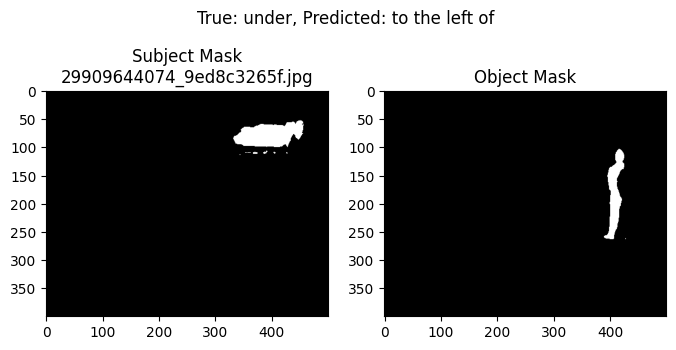

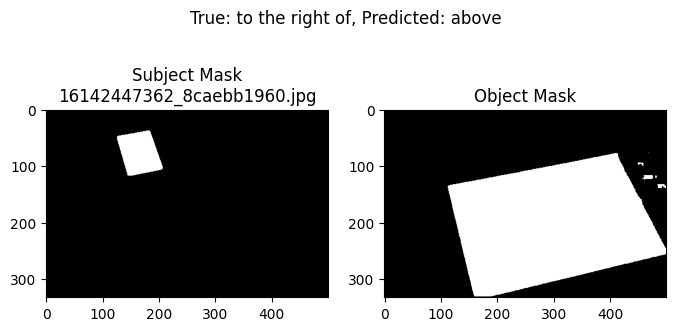

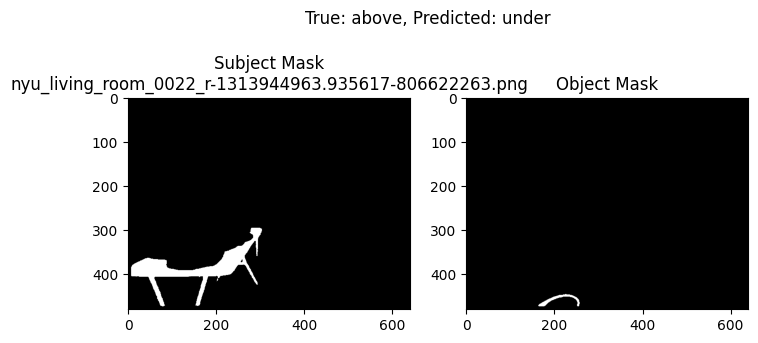

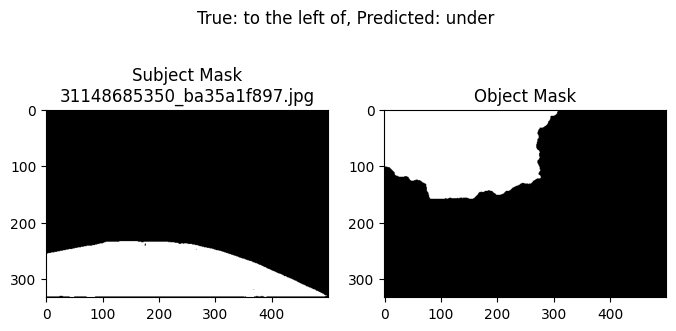

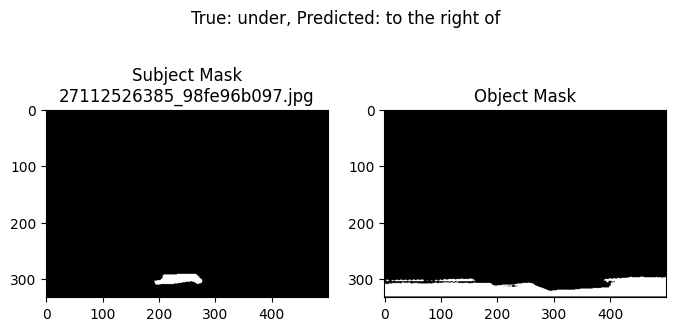

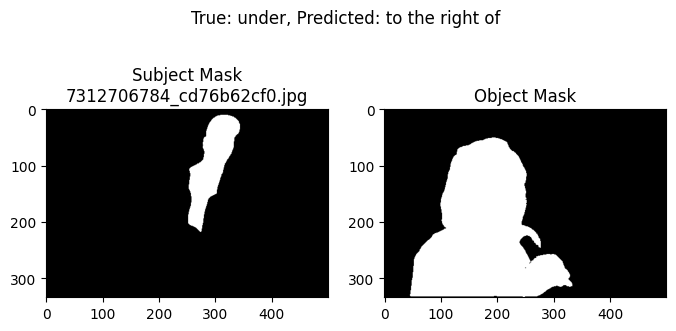

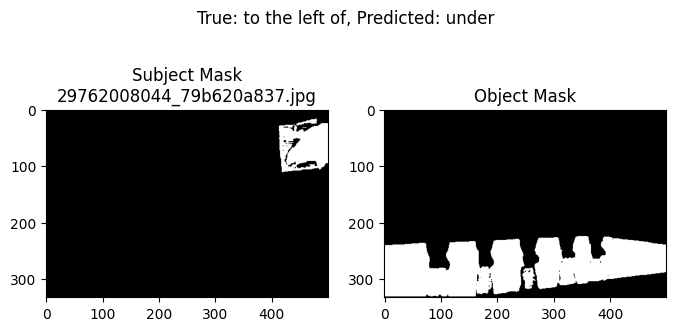

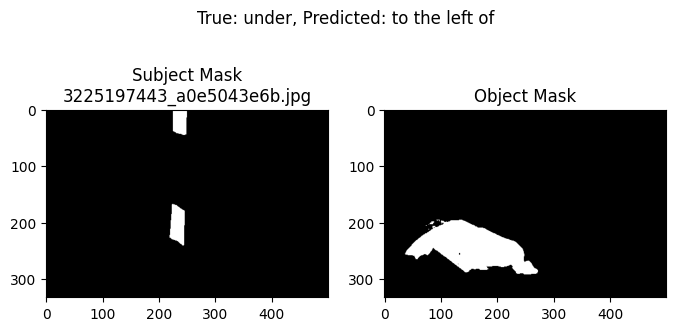

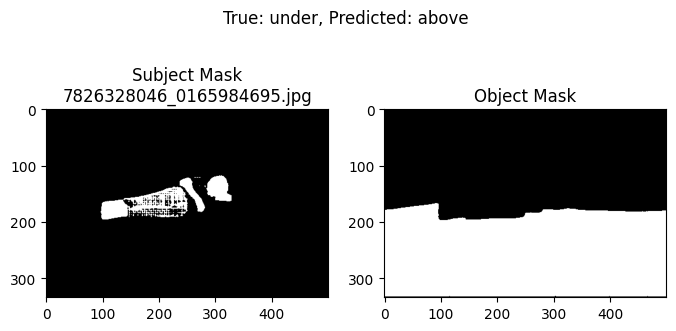

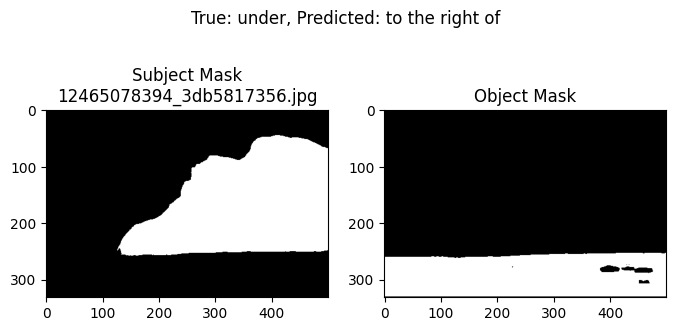

In [9]:
model = train_mlp(X, y, dataset, images_folder)

In [10]:
def visualize_example_with_original(image_name, image, images_folder, ):
    """
    Visualize the original image, subject mask, and object mask for a single example.

    :param row: Row from the dataset containing image and annotation details.
    :param images_folder: Path to the folder containing segmentation masks.
    """

    # Construct paths to the original image, subject mask, and object mask
    original_image_path = os.path.join(image, image_name)
    subject_mask_path = os.path.join(images_folder, f"{os.path.splitext(image_name)[0]}_subject_mask_1.png")
    object_mask_path = os.path.join(images_folder, f"{os.path.splitext(image_name)[0]}_object_mask_1.png")

    try:
        # Load the images
        original_image = Image.open(original_image_path)
        subject_image = Image.open(subject_mask_path)
        object_image = Image.open(object_mask_path)

        # Plot the images
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(subject_image, cmap="gray")
        plt.title("Subject Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(object_image, cmap="gray")
        plt.title("Object Mask")

        plt.suptitle(f"Image: {image_name}")
        plt.show()
    except Exception as e:
        print(f"Error loading images for {image_name} with annotation : {e}")


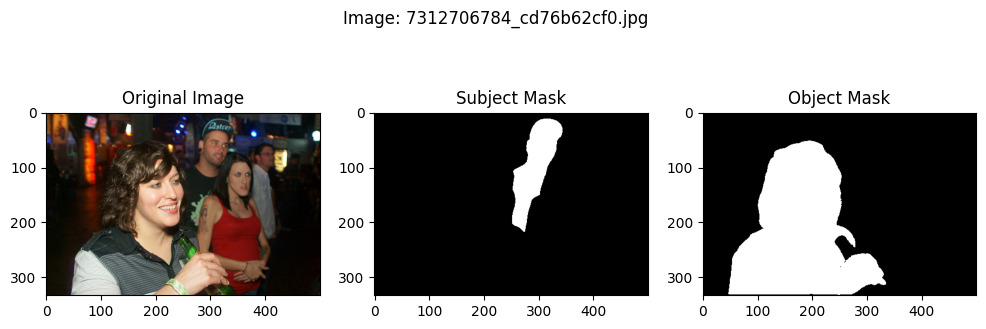

In [11]:
image = "/content/drive/MyDrive/Colab Notebooks/Mod_sys_vis/spatialsense/images/images/flickr"
image_name = "7312706784_cd76b62cf0.jpg"
visualize_example_with_original(image_name, image, images_folder)
